Fitted SAR: S = 0.03 * A^1.35


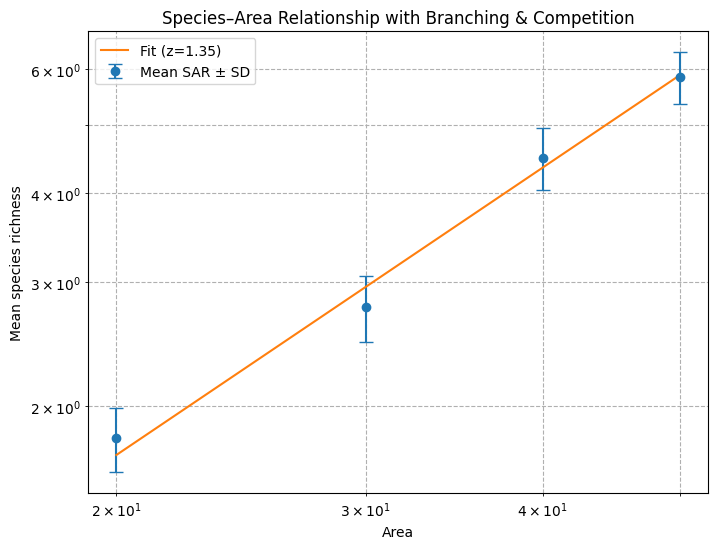

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from collections import Counter
from scipy.optimize import curve_fit

# =========================
# PARAMETERS
# =========================
Lx, Ly = 200, 200
n_species = 20
radius = 1.0
threshold_intake = 0.1
n_runs = 50
grid_sizes = [20, 30, 40, 50]  

# Log-spaced competition coefficients
comp_values = np.logspace(-2, 1, n_species)

# Branching parameters
species_alpha = np.linspace(0.6, 0.95, n_species)

# =========================
# BRANCHING MODEL
# =========================
class Branch(Enum):
    LEFT = 1
    RIGHT = 2
    BOTH = 4

class Individual:
    def __init__(self, x, y, theta, species_id=None, comp=None):
        self.x = x
        self.y = y
        self.theta = theta
        self.species_id = species_id
        self.comp = comp

class Field:
    def __init__(self, species_alpha, m, l, delta0, delta_diff, d, L_av):
        self.species_alpha = species_alpha
        self.m = m
        self.l = l
        self.delta0 = delta0
        self.delta_diff = delta_diff
        self.d = d
        self.L_av = L_av
        self.points = []

        for alpha in self.species_alpha:
            self.points.append(self.generate_species(alpha))

    def generate_species(self, alpha):
        p = [1 - alpha, 1 - alpha, 2*alpha - 1]
        theta0 = np.random.uniform(0, 2*np.pi)
        r0 = self.get_initial_point()
        points = [Individual(r0.x, r0.y, theta0)]
        l = self.l

        for n in range(1, self.m + 1):
            l /= 2
            new_points = []

            delta_max = self.delta0 * (self.delta_diff)**(2*(n//2)/self.m)

            for p0 in points:
                delta = np.random.uniform(-delta_max, delta_max)
                theta = p0.theta + np.pi/2 + delta
                branch = np.random.choice([Branch.LEFT, Branch.RIGHT, Branch.BOTH], p=p)

                if branch in (Branch.LEFT, Branch.BOTH):
                    new_points.append(Individual(
                        p0.x + l*np.cos(theta),
                        p0.y + l*np.sin(theta),
                        theta
                    ))
                if branch in (Branch.RIGHT, Branch.BOTH):
                    new_points.append(Individual(
                        p0.x + l*np.cos(theta + np.pi),
                        p0.y + l*np.sin(theta + np.pi),
                        theta + np.pi
                    ))

            points = new_points

        return points

    def get_initial_point(self):
        offset = np.random.rand() * self.d
        radian = np.random.rand() * 2*np.pi
        return Individual(offset*np.cos(radian), offset*np.sin(radian), 0)

# =========================
# ECOLOGY FUNCTIONS
# =========================
def ind_resource_species(ind, all_inds, Res, radius):
    # Find neighbors
    neighbours = [
        j for j in all_inds
        if j != ind and np.hypot(ind.x - j.x, ind.y - j.y) < radius
    ]
    total_comp = sum(j.comp for j in neighbours)

    # Clip indices to grid
    x_idx = int(np.clip(ind.x, 0, Res.shape[0]-1))
    y_idx = int(np.clip(ind.y, 0, Res.shape[1]-1))

    available = Res[x_idx, y_idx]
    return available / (1 + total_comp)

def species_richness_grid(surviving_inds, grid_size):
    richness = []
    for i in range(0, Lx, grid_size):
        for j in range(0, Ly, grid_size):
            sub = [
                ind for ind in surviving_inds
                if i <= ind.x < i + grid_size and j <= ind.y < j + grid_size
            ]
            richness.append(len(set(ind.species_id for ind in sub)))
    return np.array(richness)

def power_law(A, c, z):
    return c * A**z

# =========================
# SIMULATION
# =========================
SAR_runs = []

for run in range(n_runs):
    # Generate resource field
    Res = np.random.gamma(shape=2.0, scale=1.0, size=(Lx, Ly))

    # Generate branching field
    field = Field(
        species_alpha=species_alpha,
        m=10,
        l=40,
        delta0=0.2,
        delta_diff=1.2,
        d=5,
        L_av=Lx
    )

    # Flatten all individuals
    all_inds = [ind for species in field.points for ind in species]

    # =========================
    # RESCALE COORDINATES FOR ENTIRE COMMUNITY
    # =========================
    xs = np.array([ind.x for ind in all_inds])
    ys = np.array([ind.y for ind in all_inds])
    x_range = xs.max() - xs.min()
    y_range = ys.max() - ys.min()

    xs_rescaled = (xs - xs.min()) / x_range * (Lx-1) if x_range != 0 else np.full_like(xs, Lx/2)
    ys_rescaled = (ys - ys.min()) / y_range * (Ly-1) if y_range != 0 else np.full_like(ys, Ly/2)

    for i, ind in enumerate(all_inds):
        ind.x = xs_rescaled[i]
        ind.y = ys_rescaled[i]
        # Assign species ID and competition
        # Determine species_id by index
        for s, species in enumerate(field.points):
            if ind in species:
                ind.species_id = s
                ind.comp = comp_values[s]
                break

    # =========================
    # COMPUTE SURVIVAL
    # =========================
    surviving_inds = []
    for ind in all_inds:
        intake = ind_resource_species(ind, all_inds, Res, radius)
        if intake >= threshold_intake:
            surviving_inds.append(ind)

    # =========================
    # COMPUTE SAR
    # =========================
    SAR_run = []
    for gs in grid_sizes:
        richness = species_richness_grid(surviving_inds, gs)
        SAR_run.append(np.mean(richness))
    SAR_runs.append(SAR_run)

SAR_runs = np.array(SAR_runs)
SAR_mean = SAR_runs.mean(axis=0)
SAR_std = SAR_runs.std(axis=0)

# =========================
# FIT POWER LAW
# =========================
params, _ = curve_fit(power_law, np.array(grid_sizes), SAR_mean, p0=[1, 0.2])
c_fit, z_fit = params
print(f"Fitted SAR: S = {c_fit:.2f} * A^{z_fit:.2f}")

# =========================
# PLOT
# =========================
plt.figure(figsize=(8,6))
plt.errorbar(grid_sizes, SAR_mean, yerr=SAR_std, fmt='o', capsize=5, label='Mean SAR ± SD')
plt.loglog(grid_sizes, power_law(np.array(grid_sizes), *params), '-', label=f'Fit (z={z_fit:.2f})')
plt.xlabel("Area")
plt.ylabel("Mean species richness")
plt.title("Species–Area Relationship with Branching & Competition")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()